[Squeeze-and-Excitation模块]
https://github.com/moskomule/senet.pytorch

[环境要求]
- torch
- torchvision

In [217]:
from torch import nn

In [218]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # 全局平均池化
        y = self.fc(y).view(b, c, 1, 1) # 使用全连接层得到权重
        return x * y.expand_as(x)       # 输入特征x乘以注意力权重y

In [219]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [220]:
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv = conv3x3(inplanes, planes, stride)   ## debug: add a upper conv moudle
        self.bn = nn.BatchNorm2d(planes)
        self.conv1 = conv3x3(planes, planes, 1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)    # 声明SE模块
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = self.conv(x)   ## debug: add a upper conv moudle
        out = self.bn(residual)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)                      # 在模型中使用SE模块

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [221]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#### 定义通用的ResNet结构

In [222]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=100):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 生成一个ResNet的基本单元
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # 向前传播
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

#### 基于SE模块搭建ResNet模型，并打印网络结构

In [223]:
model = ResNet(SEBasicBlock, [1, 1, 1, 1])
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): SEBasicBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_

#### 设置使用GPU或CPU

In [224]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#### 设置模型为GPU或CPU

In [225]:
model = model.to(device)

#### 定义损失函数

In [226]:
criterion = nn.CrossEntropyLoss()

#### 定义优化器

In [227]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### 模型训练函数

In [228]:
from IPython.display import clear_output

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
    since = time.time()

    # 定义记录最优模型以及最高准确率的变量
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一个epoch包括训练和验证两个阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为验证模式

            running_loss = 0.0
            running_corrects = 0

            # 在训练数据上迭代
            for inputs, labels in dataloaders[phase]:
                # 设置输入图像和标签为GPU或CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 优化器的参数归零
                optimizer.zero_grad()

                # 向前传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 若为训练模式，则反传梯度并更新模型参数
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 记录信息
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # 若为训练模式，则更新优化器的参数
            if phase == 'train':
                scheduler.step()

            # 记录并打印信息
            clear_output()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 保存在验证集上性能最优的模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # 打印信息
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载性能最优的模型
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

#### CIFAR-100数据集图像的均值和方差

In [229]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

#### 训练数据使用随机切割、水平翻转、随机旋转的数据增强，并进行归一化处理
#### 验证数据仅使用归一化，不进行数据增强

In [230]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
    ]),
}

#### 搭建训练和验证数据集

In [231]:
Mode = {'train':True, 'val':False}

image_datasets = {x: datasets.CIFAR100(root=os.path.join('cifar', x), train=Mode[x],
                                          transform=data_transforms[x],
                                          download=True)
                  for x in ['train', 'val']}

Files already downloaded and verified
Files already downloaded and verified


In [232]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=Mode[x], num_workers=0)
               for x in ['train', 'val']}

#### 获取数据集大小

In [233]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#### 获取数据集的类别

In [234]:
class_names = image_datasets['train'].classes

#### 图像展示函数

In [235]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)

#### 从数据集中取出一组样本

In [236]:
inputs, classes = next(iter(dataloaders['train']))

#### 将一组样本拼成一幅图像

In [237]:
out = torchvision.utils.make_grid(inputs)
print(out.shape)

torch.Size([3, 274, 274])


#### 在屏幕中展示图像

In [238]:
# plt.ion()
# imshow(out, title=[class_names[x] for x in classes])

In [239]:
model, train_losses, train_acc, val_losses, val_acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

val Loss: 1.4482 Acc: 0.5939

Training complete in 31m 15s
Best val Acc: 0.593900


In [240]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu().numpy()
    
for i in range(len(val_acc)):
    val_acc[i] = val_acc[i].cpu().numpy()

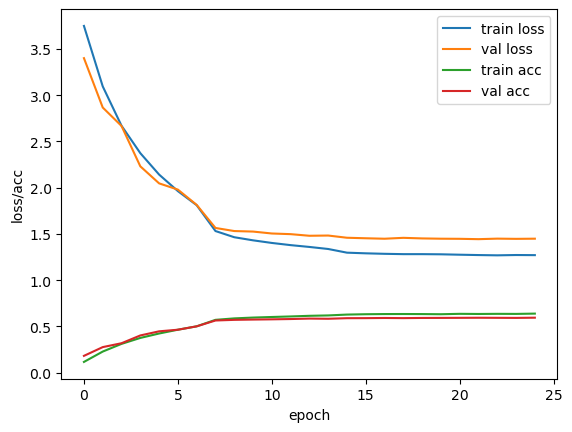

In [241]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.savefig("pic/resnet18.png")
plt.show()

#### val Loss: 1.4482 Acc: 0.5939
#### Training complete in 31m 15s
#### Best val Acc: 0.593900

### 实验结果
* 显然，实验效果相比于未加attention，有轻微提升且过拟合现象更为显著
* 新添加的se模块有bug，对于通道数有改变的模块无法完成残差操作，需要先统一维度（具体已在代码中标注）
* 相比于未加attention的Resnet，所加模块数减少了一半
* 以上，便充分说明，attention对于性能的提升是显著的，且对于cifar-100数据集来说，模型已经过大

cloud


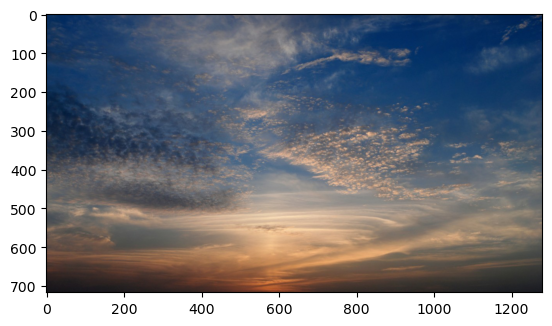

In [242]:
# Load an image and convert it to a PyTorch tensor
from PIL import Image
img = Image.open("pic/test.jpg")

img_tensor = data_transforms['val'](img)

# Expand dimensions to match the model's input shape
img_tensor = img_tensor.unsqueeze(0)

# Predict the image's class
model.eval()
predictions = model.forward(img_tensor.to(device))
print(class_names[predictions.argmax()])
plt.imshow(img)